# Example Usage

Example file that compares linear EDMDc, bilinear EDMDc, nonlinear EDMDc, and PI-EDMDc for the simple case of a slow manifold with nonlinear forcing.

Uses delay coordinates

In [2]:
import numpy as np
import torch
np.set_printoptions(precision=5, suppress=True)
torch.set_printoptions(precision=5, sci_mode=False)

import matplotlib as mpl
import matplotlib.pyplot as plt

from d_edmdc import D_EDMDc
from nl_edmdc import NL_EDMDc
from edmdc import EDMDc
from dpi_edmdc import DPI_EDMDc
from pi_edmdc import PI_EDMDc
from poly_features import PolyFeatures_np, PolyFeatures_torch

## Setup

In [4]:
def gen_delay(X, U, delay):
  '''
  Given X data matrix and U data matrix and delay, compute time-delayed matrix.

  Assumes X is made of contiguous samples in time i.e.
  [ x1  x2  x3  ... ]

  Args:
    X: [N, D_STATE]
    U: [N, D_INPUT]
    delay: int

  Outputs:
    X: [N-delay, D_STATE*(delay+1)]
    U: [N-delay, D_INPUT]
  '''

  '''
  [u0 u1 u2 u3 u4 ...] &
  [x0 x1 x2 x3 x4 ...] =>

  etc. vertically
  [x2 x3 x4 x5 ...] delay = 2
  [x1 x2 x3 x4 ...] delay = 1
  [x0 x1 x2 x3 ...] delay = 0
  '''
  N, D_STATE = X.shape
  _, D_INPUT = U.shape

  res_X = np.zeros((N-delay, D_STATE*(delay+1)))

  for i in range(delay+1):
    res_X[:,D_STATE*i:D_STATE*(i+1)] = X[delay-i:N-i,:]
  
  return res_X, U[delay:,:]

## Brunton Slow Manifold

In [5]:

#===============#
# GENERATE DATA #
#===============#

def rk4(t0, u0, inp, dt, f):
    f1 = f(t0,            u0,                 inp)
    f2 = f(t0 + dt / 2.0, u0 + dt * f1 / 2.0, inp)
    f3 = f(t0 + dt / 2.0, u0 + dt * f2 / 2.0, inp)
    f4 = f(t0 + dt,       u0 + dt * f3,       inp)

    u1 = u0 + dt * (f1 + 2.0 * f2 + 2.0 * f3 + f4) / 6.0
    return u1

MU = -0.1
LMBDA = -1
DELTA = 10
dt = 1e-3

def f(t, x, u):
    x1, x2 = x
    dx1 = MU * x1
    dx2 = LMBDA * x2 - LMBDA * np.power(x1, 2) + DELTA * np.sin(u)
    return np.array([dx1, dx2])

def gen_data(N=10000, x0=None, freq=3):
    #inputs = 0.1 * np.random.normal(size=N)
    inputs = np.zeros(N)
    t0 = 0
    #x0 = np.array([0.3, 0.7])
    if x0 is None:
        x0 = np.random.rand(2)

    Y = np.zeros((N, 2))
    T = np.zeros(N)
    Y[0,:] = x0

    t = t0
    for i in range(1, N):
        if (i-1) % freq == 0:
            inputs[i] = 0.1 * np.random.normal()
        else:
            inputs[i] = inputs[i-1]
        
        Y[i,:] = rk4(t, Y[i-1,:], inputs[i-1], dt, f)
        t += dt
        T[i] = t

    return Y, inputs[:,None], T

def t_f(x):
    # (TIME, 2)
    TIME, _ = x.shape
    x1, x2 = x[:,0], x[:,1]
    dx1 = MU * x1
    dx2 = LMBDA * x2 - LMBDA * torch.pow(x1, 2)
    return torch.cat((dx1.view((TIME, 1)), dx2.view((TIME, 1))), 1)


In [6]:
X_train, inp_train, _ = gen_data(10000, x0=np.array([0.3, 0.7]))

def t_train_model(features, xu_features, num_trajectories, num_timesteps, delay=1):
    dtrajectories = []
    dinputs = []

    for _ in range(num_trajectories):
        # Y, inp, _ = gen_data(num_timesteps)
        Y = X_train[:num_timesteps]
        inp = inp_train[:num_timesteps]
        
        # Delay coordinates
        Y = Y[::-1]
        
        delays = []
        for i in range(delay):
            delays.append(Y[i:num_timesteps-delay+1+i])
        delays = np.concatenate(delays, axis=1)
        
        delays = delays[::-1]
        
        dtrajectories.append(delays)
        dinputs.append(inp[delay-1:])
    
    dtrajectories = np.array(dtrajectories)
    dinputs = np.array(dinputs)
    
    Xd = torch.tensor(dtrajectories[:,:-1,:].reshape(-1, 2*delay), dtype=torch.float64)
    Ud = torch.tensor(dinputs[:,:-1,:].reshape(-1, 1), dtype=torch.float64)
    Yd = torch.tensor(dtrajectories[:,1:,:2].reshape(-1, 2), dtype=torch.float64)
    
    if delay > 1:
        p_edmdc = DPI_EDMDc(features, xu_features, t_f, dt)
    else:
        p_edmdc = PI_EDMDc(features, xu_features, t_f, dt)
    p_edmdc.fit(Xd, Ud, Yd)
    return p_edmdc

def train_model(features, num_trajectories, num_timesteps, delay=1, linear=True, xu_features=None):
    od = delay
    delay = np.abs(delay)
    
    dtrajectories = []
    dinputs = []

    for _ in range(num_trajectories):
        # Y, inp, _ = gen_data(num_timesteps)
        Y = X_train[:num_timesteps]
        inp = inp_train[:num_timesteps]
        
        # Delay coordinates
        Y = Y[::-1]
        
        delays = []
        for i in range(delay):
            delays.append(Y[i:num_timesteps-delay+1+i])
        delays = np.concatenate(delays, axis=1)
        
        delays = delays[::-1]
        
        dtrajectories.append(delays)
        dinputs.append(inp[delay-1:])
    
    dtrajectories = np.array(dtrajectories)
    dinputs = np.array(dinputs)
    
    Xd = dtrajectories[:,:-1,:].reshape(-1, 2*delay)
    Ud = dinputs[:,:-1,:].reshape(-1, 1)
    Yd = dtrajectories[:,1:,:2].reshape(-1, 2)
    
    if od == -1:
        l_edmdc = NL_EDMDc(features, xu_features)
    elif od > 1:
        l_edmdc = D_EDMDc(features)
    else:
        l_edmdc = EDMDc(features)
    
    l_edmdc.fit(Xd, Ud, Yd, linear=linear)
    
    return l_edmdc

def construct_delay_x0(X, U, delay):
    # Construct delay coordinate initial condition
    inp_delay = U[delay-1:]

    delays = []
    for i in range(delay):
        delays.append(X[delay-i-1,:])
    delays = np.concatenate(delays)

    x0 = delays
    
    return x0, inp_delay

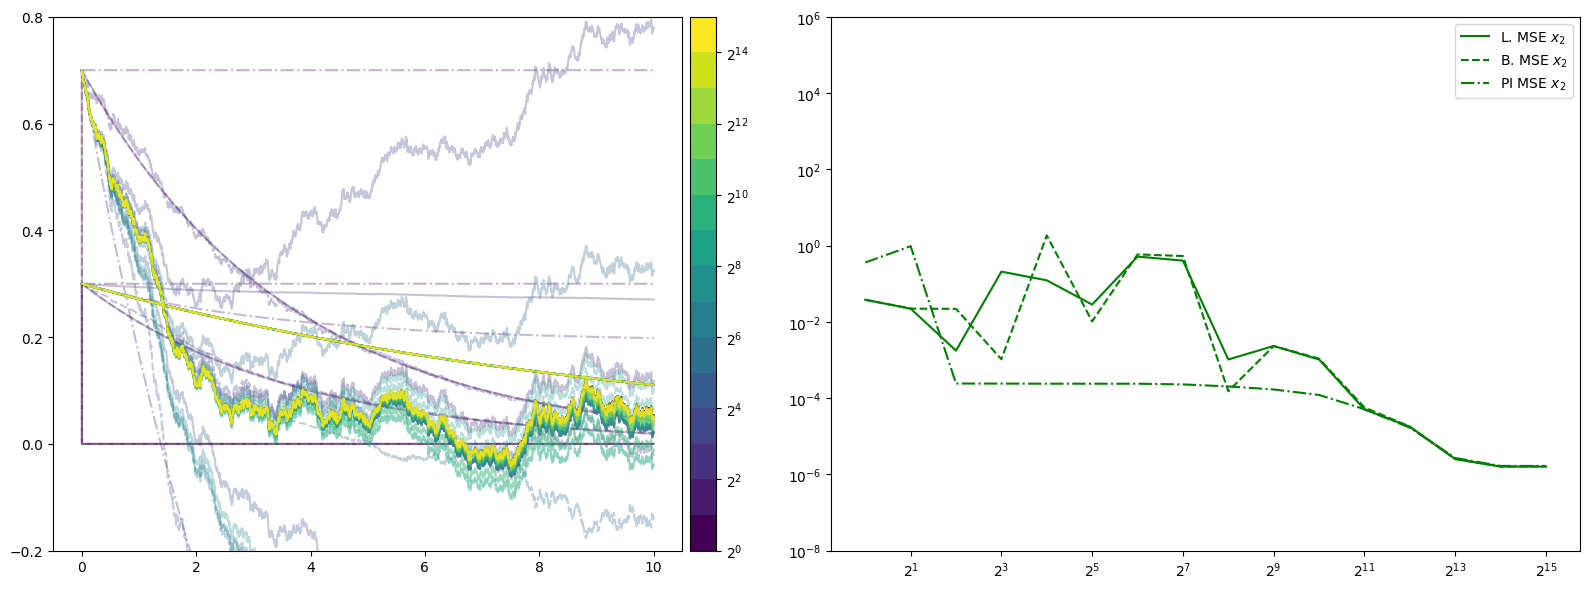

In [6]:
X_test, inp, T = gen_data(10000, x0=np.array([0.3, 0.7]))

samp_size = 2**np.arange(16)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].plot(T, X_test[:,0], label='True $x_1$', c='k')
axs[0].plot(T, X_test[:,1], label='True $x_2$', c='k')

log_sizes = np.log2(samp_size)
r_cmap = mpl.colormaps['viridis']
inds = []

l_mses_x1 = []
l_mses_x2 = []
b_mses_x1 = []
b_mses_x2 = []
p_mses_x1 = []
p_mses_x2 = []
n_mses_x1 = []
n_mses_x2 = []

delay = 1

for i, size in enumerate(samp_size):
    ind = (log_sizes[i] - log_sizes.min()) / (log_sizes.max() - log_sizes.min())
    inds.append(size)
    
    # xu_feat = PolyFeatures_np(order=2, mono=True)
    xu_feat = None
    
    l_edmdc = train_model(PolyFeatures_np(order=1, mono=True), 1, size, delay=delay, linear=True)
    bledmdc = train_model(PolyFeatures_np(order=1, mono=True), 1, size, delay=delay, linear=False)
    # nledmdc = train_model(PolyFeatures_np(order=1, mono=True), 1, size, delay=-1, linear=False, xu_features=xu_feat)
    
    p_edmdc_x_feat = PolyFeatures_torch(order=1, mono=True)
    p_edmdc_xu_feat = None
    # p_edmdc_xu_feat = PolyFeatures_torch(order=2, mono=True)
    # p_edmdc_xu_feat = FourierFeatures_torch(n_components=50, gamma=0.1)
    
    p_edmdc = t_train_model(p_edmdc_x_feat, p_edmdc_xu_feat, 1, size, delay=delay)
    
    x0, inp_delay = construct_delay_x0(X_test, inp, delay)
    x01, inp_delay1 = construct_delay_x0(X_test, inp, 1)
    
    l_Y = l_edmdc.predict(x0, inp_delay)
    b_Y = bledmdc.predict(x0, inp_delay)
    p_Y, _ = p_edmdc.predict(torch.tensor(x0, dtype=torch.float64), torch.tensor(inp_delay, dtype=torch.float64))
    # n_Y = nledmdc.predict(x01, inp_delay1)
    
    axs[0].plot(T[:len(T)-delay+1], l_Y[:,0][:-1], label=f'L, UD, {size} $x_1$', c=r_cmap(ind), alpha=0.3)
    axs[0].plot(T[:len(T)-delay+1], l_Y[:,1][:-1], label=f'L, UD, {size} $x_2$', c=r_cmap(ind), alpha=0.3)
    
    axs[0].plot(T[:len(T)-delay+1], b_Y[:,0][:-1], label=f'B, UD, {size} $x_1$', c=r_cmap(ind), alpha=0.3, linestyle='--')
    axs[0].plot(T[:len(T)-delay+1], b_Y[:,1][:-1], label=f'B, UD, {size} $x_2$', c=r_cmap(ind), alpha=0.3, linestyle='--')
    
    axs[0].plot(T[:len(T)-delay+1], p_Y[:,0][:-1], label=f'PI, UD, {size} $x_1$', c=r_cmap(ind), alpha=0.3, linestyle='-.')
    axs[0].plot(T[:len(T)-delay+1], p_Y[:,1][:-1], label=f'PI, UD, {size} $x_2$', c=r_cmap(ind), alpha=0.3, linestyle='-.')
    
    # axs[0].plot(T, n_Y[:,0][:-1], label=f'NL, UD, {size} $x_1$', c=r_cmap(ind), alpha=0.3, linestyle=':')
    # axs[0].plot(T, n_Y[:,1][:-1], label=f'NL, UD, {size} $x_2$', c=r_cmap(ind), alpha=0.3, linestyle=':')
    
    # Compute MSE
    l_mse_x1 = np.mean(np.square(l_Y[:-1,0] - X_test[:len(T)-delay+1,0]))
    l_mse_x2 = np.mean(np.square(l_Y[:-1,1] - X_test[:len(T)-delay+1,1]))
    l_mses_x1.append(l_mse_x1)
    l_mses_x2.append(l_mse_x2)
    
    b_mse_x1 = np.mean(np.square(b_Y[:-1,0] - X_test[:len(T)-delay+1,0]))
    b_mse_x2 = np.mean(np.square(b_Y[:-1,1] - X_test[:len(T)-delay+1,1]))
    b_mses_x1.append(b_mse_x1)
    b_mses_x2.append(b_mse_x2)
    
    p_mse_x1 = np.mean(np.square(p_Y[:-1,0] - X_test[:len(T)-delay+1,0]))
    p_mse_x2 = np.mean(np.square(p_Y[:-1,1] - X_test[:len(T)-delay+1,1]))
    p_mses_x1.append(p_mse_x1)
    p_mses_x2.append(p_mse_x2)
    
    # n_mse_x1 = np.mean(np.square(n_Y[:-1,0] - X_test[:,0]))
    # n_mse_x2 = np.mean(np.square(n_Y[:-1,1] - X_test[:,1]))
    # n_mses_x1.append(n_mse_x1)
    # n_mses_x2.append(n_mse_x2)

r_sm = plt.cm.ScalarMappable(cmap=r_cmap, norm=mpl.colors.BoundaryNorm(inds, r_cmap.N))

rbar = plt.colorbar(r_sm, ax=axs[0], pad=0.01)
rbar.ax.set_yscale('log', base=2)

axs[0].set_ylim(-0.2, 0.8)

# axs[1].plot(samp_size, l_mses_x1, label='L. MSE $x_1$', c='b')
axs[1].plot(samp_size, l_mses_x2, label='L. MSE $x_2$', c='g')
# axs[1].plot(samp_size, b_mses_x1, label='B. MSE $x_1$', c='b', linestyle='--')
axs[1].plot(samp_size, b_mses_x2, label='B. MSE $x_2$', c='g', linestyle='--')
# axs[1].plot(samp_size, p_mses_x1, label='PI MSE $x_1$', c='b', linestyle='-.')
axs[1].plot(samp_size, p_mses_x2, label='PI MSE $x_2$', c='g', linestyle='-.')
# axs[1].plot(samp_size, n_mses_x1, label='NL MSE $x_1$', c='b', linestyle=':')
# axs[1].plot(samp_size, n_mses_x2, label='NL MSE $x_2$', c='g', linestyle=':')

axs[1].set_xscale('log', base=2)
axs[1].set_yscale('log')
axs[1].legend()

axs[1].set_ylim(1e-8, 1e6)

plt.tight_layout()
plt.show()